<a href="https://colab.research.google.com/github/SauravMaheshkar/trax/blob/SauravMaheshkar-example-1/examples/NER_using_Reformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
# Copyright 2020 Google LLC.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Author - [@SauravMaheshkar](https://github.com/SauravMaheshkar)

# Install Dependencies


Install the latest version of the [Trax](https://github.com/google/trax) Library.

In [ ]:
!pip install -q -U trax

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pytorch-lightning 0.9.0 requires tensorboard==2.2.0, but you'll have tensorboard 2.3.0 which is incompatible.
kfac 0.2.3 requires tensorflow-probability==0.8, but you'll have tensorflow-probability 0.7.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Introduction


---

**Named-entity recognition** (NER) is a subtask of *information extraction* that seeks to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

To evaluate the quality of a NER system's output, several measures have been defined. The usual measures are called **Precision**, **recall**, and **F1 score**. However, several issues remain in just how to calculate those values. State-of-the-art NER systems for English produce near-human performance. For example, the best system entering MUC-7 scored 93.39% of F-measure while human annotators scored 97.60% and 96.95%.

# Importing Packages

In [ ]:
import trax # Our Main Library
from trax import layers as tl
import os # For os dependent functionalities
import numpy as np # For scientific computing
import pandas as pd # For basic data analysis
import random as rnd # For using random functions

# Pre-Processing

## Loading the Dataset

Let's load the `ner_dataset.csv` file into a dataframe and see what it looks like

In [ ]:
data = pd.read_csv("/kaggle/input/entity-annotated-corpus/ner_dataset.csv",encoding = 'ISO-8859-1')
data = data.fillna(method = 'ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


## Creating a Vocabulary File

We can see there's a column for the words in each sentence. Thus, we can extract this column using the [`.loc()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) and store it into a `.txt` file using the [`.savetext()`](https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html) function from numpy.

In [ ]:
## Extract the 'Word' column from the dataframe
words = data.loc[:, "Word"]

## Convert into a text file using the .savetxt() function
np.savetxt(r'words.txt', words.values, fmt="%s")

## Creating a Dictionary for Vocabulary

Here, we create a Dictionary for our vocabulary by reading through all the sentences in the dataset.

In [ ]:
vocab = {}
with open('words.txt') as f:
  for i, l in enumerate(f.read().splitlines()):
    vocab[l] = i
  print("Number of words:", len(vocab))
  vocab['<PAD>'] = len(vocab)

Number of words: 35178


## Extracting Sentences from the Dataset

For extracting sentences from the dataset and creating (X,y) pairs for training.

In [ ]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent=1
        self.data = data
        agg_func = lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                     s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = Get_sentence(data)
sentence = getter.sentences

In [ ]:
words = list(set(data["Word"].values))
words_tag = list(set(data["Tag"].values))

word_idx = {w : i+1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(words_tag)}

In [ ]:
X = [[word_idx[w[0]] for w in s] for s in sentence]
y = [[tag_idx[w[2]] for w in s] for s in sentence]

## Making a Batch Generator

Here, we create a batch generator for training. 

In [ ]:
def data_generator(batch_size, x, y,pad, shuffle=False, verbose=False):

    num_lines = len(x)
    lines_index = [*range(num_lines)]
    if shuffle:
        rnd.shuffle(lines_index)
    
    index = 0 
    while True:
        buffer_x = [0] * batch_size 
        buffer_y = [0] * batch_size 

        max_len = 0
        for i in range(batch_size):
            if index >= num_lines:
                index = 0
                if shuffle:
                    rnd.shuffle(lines_index)
            
            buffer_x[i] = x[lines_index[index]]
            buffer_y[i] = y[lines_index[index]]
            
            lenx = len(x[lines_index[index]])    
            if lenx > max_len:
                max_len = lenx                  
            
            index += 1

        X = np.full((batch_size, max_len), pad)
        Y = np.full((batch_size, max_len), pad)


        for i in range(batch_size):
            x_i = buffer_x[i]
            y_i = buffer_y[i]

            for j in range(len(x_i)):

                X[i, j] = x_i[j]
                Y[i, j] = y_i[j]

        if verbose: print("index=", index)
        yield((X,Y))

## Splitting into Test and Train 

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=1)

# Building the Model

## The Reformer Model

In this notebook, we use the Reformer, which is a more efficient of Transformer that uses reversible layers and locality-sensitive hashing. You can read the original paper [here](https://arxiv.org/abs/2001.04451). 


### Locality-Sensitive Hashing


---
The biggest problem that one might encounter while using Transformers, for huge corpora is the handling of the attention layer. Reformer introduces Locality Sensitive Hashing to solve this problem, by computing a hash function that groups similar vectors together. Thus, a input sequence is rearranged to bring elements with the same hash together and then divide into segments(or *chunks*, *buckets*) to enable parallel processing. Thus, we can apply Attention to these chunks (rather than the whole input sequence) to reduce the computational load.

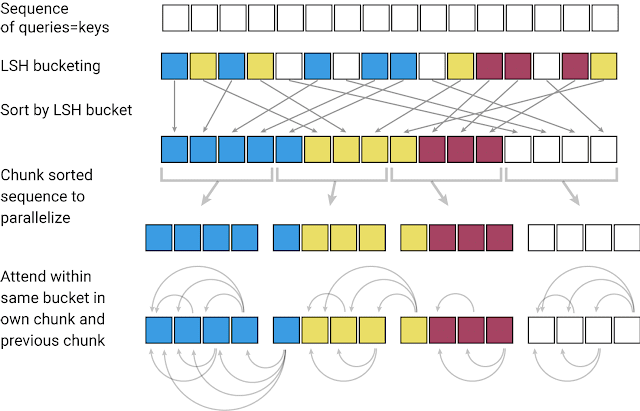

### Reversible Layers

---

Using Locality Sensitive Hashing, we were able to solve the problem of computation but still we have a memory issue. Reformer implements a novel approach to solve this problem, by recomputing the input of each layer on-demand during back-propagation, rather than storing it in memory. This is accomplished by using Reversible Layers (*activations from last layers are used to recover activations from any intermediate layer*). 

Reversible layers store two sets of activations for each layer. 

- One follows the standard procedure in which the activations are added as they pass through the network

- The other set only captures the changes. Thus, if we run the network in reverse, we simply subtract the activations applied at each layer.

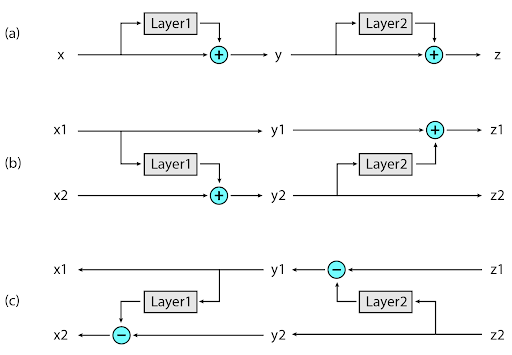

## Model Architecture

We will perform the following steps:

* Use input tensors from our data generator

* Produce Semantic entries from an Embedding Layer

* Feed these into our Reformer Language model

* Run the Output through a Linear Layer

* Run these through a log softmax layer to get predicted classes

We use the:



1. [`tl.Serial()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial): Combinator that applies layers serially(by function composition). It's commonly used to construct deep networks. It uses stack semantics to manage data for its sublayers
2. [`tl.Embedding()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding): Initializes a trainable embedding layer that maps discrete tokens/ids to vectors

3. [`trax.models.reformer.Reformer()`](https://trax-ml.readthedocs.io/en/latest/trax.models.html#trax.models.reformer.reformer.Reformer): Creates a Reversible Transformer encoder-decoder model.

4. [`tl.Dense()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense): Creates a Dense(*fully-connected, affine*) layer

5. [`tl.LogSoftmax()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax): Creates a layer that applies log softmax along one tensor axis.



In [ ]:
def NERmodel(tags, vocab_size=35181, d_model = 50):

  model = tl.Serial(
    # tl.Embedding(vocab_size, d_model),
    trax.models.reformer.Reformer(vocab_size, d_model, ff_activation=tl.LogSoftmax),
    tl.Dense(tags),
    tl.LogSoftmax()
  )

  return model

In [ ]:
model = NERmodel(tags = 17)

print(model)

Serial_in2_out2[
  Serial_in2_out2[
    Select[0,1,1]_in2_out3
    Branch_out2[
      []
      [PaddingMask(0), Squeeze]
    ]
    Serial_in2_out2[
      Embedding_35181_512
      Dropout
      PositionalEncoding
      Dup_out2
      ReversibleSerial_in3_out3[
        ReversibleHalfResidual_in3_out3[
          Serial[
            LayerNorm
          ]
          SelfAttention_in2
        ]
        ReversibleSwap_in2_out2
        ReversibleHalfResidual_in2_out2[
          Serial[
            LayerNorm
            Dense_2048
            Dropout
            LogSoftmax
            Dense_512
            Dropout
          ]
        ]
        ReversibleSwap_in2_out2
        ReversibleHalfResidual_in3_out3[
          Serial[
            LayerNorm
          ]
          SelfAttention_in2
        ]
        ReversibleSwap_in2_out2
        ReversibleHalfResidual_in2_out2[
          Serial[
            LayerNorm
            Dense_2048
            Dropout
            LogSoftmax
            Dense_512
 

# Train the Model

In [ ]:
from trax.supervised import training

rnd.seed(33)

batch_size = 64

train_generator = trax.data.inputs.add_loss_weights(
    data_generator(batch_size, x_train, y_train,vocab['<PAD>'], True),
    id_to_mask=vocab['<PAD>'])

eval_generator = trax.data.inputs.add_loss_weights(
    data_generator(batch_size, x_test, y_test,vocab['<PAD>'] ,True),
    id_to_mask=vocab['<PAD>'])

In [ ]:
def train_model(model, train_generator, eval_generator, train_steps=1, output_dir='model'):
    train_task = training.TrainTask(
      train_generator,  
      loss_layer = tl.CrossEntropyLoss(), 
      optimizer = trax.optimizers.Adam(0.01), 
      n_steps_per_checkpoint=10
    )

    eval_task = training.EvalTask(
      labeled_data = eval_generator, 
      metrics = [tl.CrossEntropyLoss(), tl.Accuracy()], 
      n_eval_batches = 10 
    )

    training_loop = training.Loop(
        model, 
        train_task, 
        eval_tasks = eval_task, 
        output_dir = output_dir) 

    training_loop.run(n_steps = train_steps)
    return training_loop

In [ ]:
train_steps = 100
training_loop = train_model(model, train_generator, eval_generator, train_steps)


Step      1: Ran 1 train steps in 815.40 secs
Step      1: train CrossEntropyLoss |  2.97494578
Step      1: eval  CrossEntropyLoss |  5.96823492
Step      1: eval          Accuracy |  0.85458949

Step     10: Ran 9 train steps in 6809.59 secs
Step     10: train CrossEntropyLoss |  5.27117538
Step     10: eval  CrossEntropyLoss |  5.19212604
Step     10: eval          Accuracy |  0.85005882

Step     20: Ran 10 train steps in 5372.06 secs
Step     20: train CrossEntropyLoss |  6.68565750
Step     20: eval  CrossEntropyLoss |  4.00950582
Step     20: eval          Accuracy |  0.81635543

Step     30: Ran 10 train steps in 1040.84 secs
Step     30: train CrossEntropyLoss |  3.92878985
Step     30: eval  CrossEntropyLoss |  3.32506871
Step     30: eval          Accuracy |  0.78096363

Step     40: Ran 10 train steps in 3624.02 secs
Step     40: train CrossEntropyLoss |  3.41684675
Step     40: eval  CrossEntropyLoss |  3.47973170
Step     40: eval          Accuracy |  0.84054841

Step   

# References

---

* [Google AI Blog- Reformer: The Efficient Transformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)

* [Google AI Blog- Transformer: A Novel Neural Network Architecture for Language Understanding](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)

* [Trax: Deep Learning with Clear Code and Speed](https://github.com/google/trax)

* [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)

* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

* [Illustrating the Reformer](https://towardsdatascience.com/illustrating-the-reformer-393575ac6ba0)